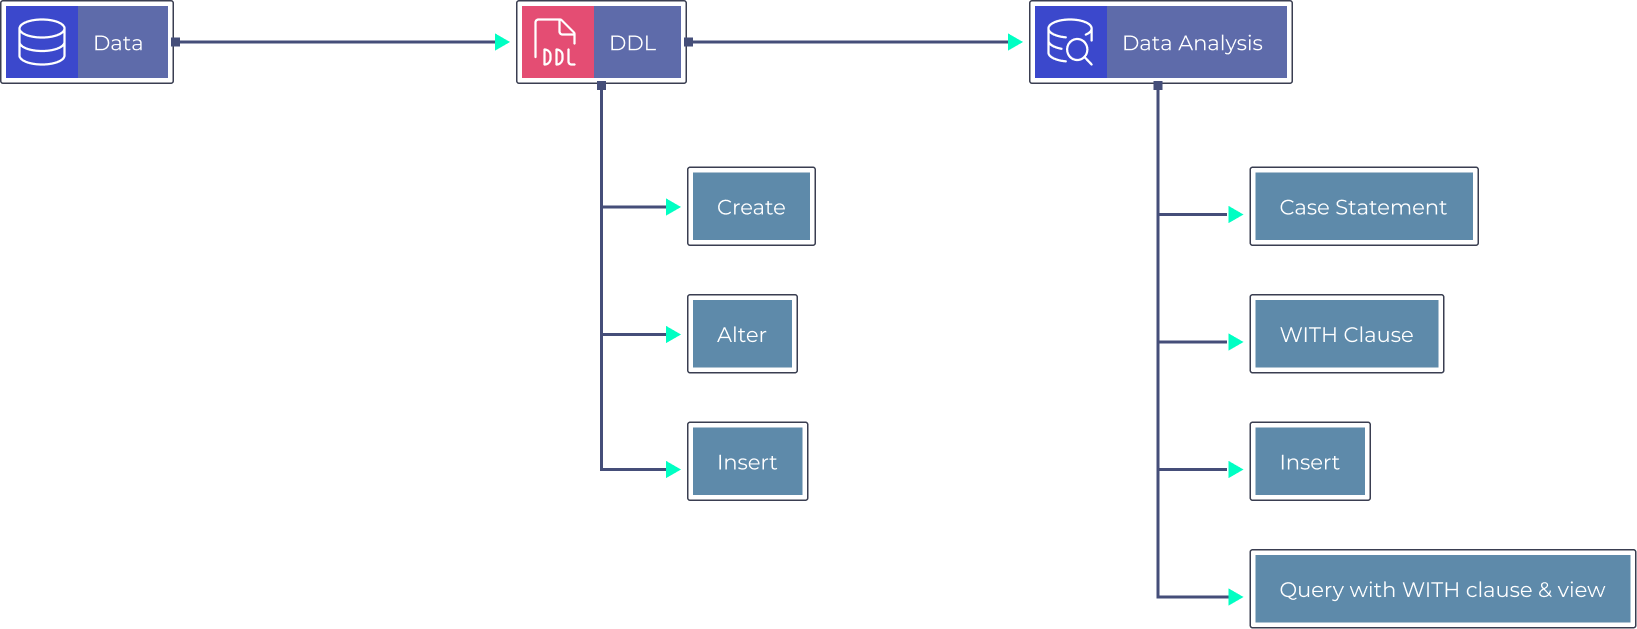

# In this SQL Project for Data Analysis, you will learn to efficiently write queries using WITH clause and analyse data using SQL Aggregate Functions and various other operators like EXISTS, HAVING.

- Understanding the project and how to use Oracle SQL Developer
- Understanding the basics of data analysis, SQL commands, and their application
- Understanding the use of Oracle SQL Developer
- Understanding the difference between COUNT(*) and COUNT(column_name).
- Data analysis using WITH clause.
- Categorization using CASE statement.
- Understanding the inline view.
- Simplify query with WITH clause and View.
- Understanding the use of the ROWNUM clause.

In [ ]:
SELECT * FROM LOCATIONS;
SELECT * FROM DEPARTMENTS;
SELECT * FROM JOBS;
SELECT * FROM EMPLOYEES;
SELECT * FROM JOB_HISTORY;
SELECT * FROM REGIONS;
SELECT * FROM COUNTRIES;
SELECT * FROM NON_FUNCTIONAL_LOCATIONS;


/************************** 1. COUNT(*) vs COUNT(column_name) **************************/

SELECT COUNTRY_ID, COUNT(*)
FROM LOCATIONS
GROUP BY COUNTRY_ID
ORDER BY COUNTRY_ID;

--country wise number of records and state

SELECT COUNTRY_ID, COUNT(*), COUNT(STATE_PROVINCE)
FROM LOCATIONS
GROUP BY COUNTRY_ID
ORDER BY COUNTRY_ID;


--Find department wise number of managers and number of records.

SELECT D.DEPARTMENT_NAME, COUNT(*), COUNT(E.MANAGER_ID)
FROM EMPLOYEES E JOIN DEPARTMENTS D
ON E.DEPARTMENT_ID = D.DEPARTMENT_ID
GROUP BY D.DEPARTMENT_NAME;




In [ ]:


/************************** 2. CASE STATEMENT: Categorize employees based on hire date **************************/

--Categorize employees based on hire date
/*
1. before 1990
2. between 1990 to 1995
3. between 1995 to 2000
4. after 90s
*/

SELECT FIRST_NAME || ' ' || LAST_NAME,
HIRE_DATE,
CASE
  WHEN HIRE_DATE < TO_DATE('01-JAN-1990', 'dd-MON-yyyy')
  THEN 'BEFORE 1990'
  WHEN HIRE_DATE >= TO_DATE('01-JAN-1990', 'dd-MON-yyyy') AND HIRE_DATE < TO_DATE('01-JAN-1995', 'dd-MON-yyyy')
  THEN 'BETWEEN 1990 TO 1995'
  WHEN HIRE_DATE >= TO_DATE('01-JAN-1995', 'dd-MON-yyyy') AND HIRE_DATE < TO_DATE('01-JAN-2000', 'dd-MON-yyyy')
  THEN 'BETWEEN 1995 TO 2000'
  WHEN HIRE_DATE >= TO_DATE('01-JAN-2000', 'dd-MON-yyyy')
  THEN 'AFTER 90s'
  ELSE
    'NOT CATEGORIZED'
END HIRE_CATEGORY
FROM EMPLOYEES
ORDER BY HIRE_DATE;



In [ ]:

/************************** 3. WITH Clause **************************/

--Find all the employee whose salary is more than the average salary of all employees.

SELECT E.EMPLOYEE_ID, SALARY, AVG_SALARY
FROM EMPLOYEES E, (SELECT AVG(SALARY) AVG_SALARY FROM EMPLOYEES) AVG_SAL
WHERE E.SALARY > AVG_SAL.AVG_SALARY;


WITH AVG_SAL AS
(SELECT ROUND(AVG(SALARY),2) AVG_SALARY
  FROM EMPLOYEES)
SELECT E.EMPLOYEE_ID, SALARY, AVG_SALARY
FROM EMPLOYEES E, AVG_SAL
WHERE E.SALARY > AVG_SAL.AVG_SALARY;


--Find all the departments where the total salary of all employee in that department is more than the average of total salary of all employees in the database.

WITH DEPT_WISE_SAL AS
  (
  SELECT DEPARTMENT_ID, SUM(SALARY) TOTAL_SAL_DEPT_WISE
  FROM EMPLOYEES
  GROUP BY DEPARTMENT_ID
  ),
AVG_SAL AS (
    SELECT AVG(SALARY) AVG_SAL
    FROM EMPLOYEES)
SELECT *
FROM DEPT_WISE_SAL, AVG_SAL
WHERE DEPT_WISE_SAL.TOTAL_SAL_DEPT_WISE > AVG_SAL.AVG_SAL;





/*
1. The SQL WITH clause is good when used with complex SQL statements rather than simple ones.
2. It also allows you to break down complex SQL queries into smaller ones which make it easy for debugging and processing the complex queries.
3. The SQL WITH clause is basically a drop-in replacement to the normal sub-query.
*/


In [ ]:

/************************** 4. Simplify query with WITH clause and View **************************/

CREATE OR REPLACE VIEW EMP_VIEW AS
SELECT EMPLOYEE_ID, FIRST_NAME, LAST_NAME, HIRE_DATE, JOB_ID, COMMISSION_PCT, MANAGER_ID, DEPARTMENT_ID FROM EMPLOYEES;

SELECT * FROM EMP_VIEW;


CREATE OR REPLACE VIEW DEPARTMENT_LEVEL_DETAIS AS
WITH DEPT_SAL_DET AS
  (SELECT DEPARTMENT_ID,
    MAX(SALARY)           AS MAX_SALARY,
    MIN(SALARY)           AS MIN_SALARY,
    ROUND(AVG(SALARY), 2) AS AVG_SALARY,
    SUM(SALARY)           AS SUM_SALARY,
    COUNT(*)              AS NUMBER_OF_EMP
  FROM EMPLOYEES
  GROUP BY DEPARTMENT_ID
  ),
EMP_RESIGNATION_DET AS
  (SELECT DEPARTMENT_ID,
    COUNT(*) AS NUMBER_OF_EMP_RESIGNED
  FROM JOB_HISTORY
  GROUP BY DEPARTMENT_ID
  )
SELECT DEPARTMENTS.DEPARTMENT_ID,
  DEPARTMENT_NAME,
  EMPLOYEES.FIRST_NAME
  || ' '
  || EMPLOYEES.LAST_NAME AS MANAGER_NAME,
  LOCATIONS.CITY,
  MAX_SALARY,
  MIN_SALARY,
  AVG_SALARY,
  SUM_SALARY,
  NUMBER_OF_EMP,
  NUMBER_OF_EMP_RESIGNED
FROM DEPARTMENTS
LEFT JOIN EMPLOYEES
ON DEPARTMENTS.MANAGER_ID = EMPLOYEES.EMPLOYEE_ID
LEFT JOIN LOCATIONS
ON DEPARTMENTS.LOCATION_ID = LOCATIONS.LOCATION_ID
LEFT JOIN DEPT_SAL_DET
ON DEPARTMENTS.DEPARTMENT_ID = DEPT_SAL_DET.DEPARTMENT_ID
LEFT JOIN EMP_RESIGNATION_DET
ON DEPARTMENTS.DEPARTMENT_ID = EMP_RESIGNATION_DET.DEPARTMENT_ID
ORDER BY DEPARTMENTS.DEPARTMENT_ID;


SELECT * FROM DEPARTMENT_LEVEL_DETAIS;




In [ ]:


/************************** 5. Fetch employee record with third MAX salary without Analytical function **************************/

/*
ROWNUM is a “Pseudocolumn” that assigns a number to each row returned by a query
indicating the order in which Oracle selects the row from a table.
The first row selected has a ROWNUM of 1, the second has 2, and so on.
*/
SELECT T.*, ROWNUM FROM EMPLOYEES T;

--DELETE DUPLICATED RECORDS
SELECT SALARY
FROM EMPLOYEES
GROUP BY SALARY
ORDER BY SALARY DESC;

--TOP 3 SALARY
SELECT * FROM
(
SELECT SALARY
FROM EMPLOYEES
GROUP BY SALARY
ORDER BY SALARY DESC
) WHERE ROWNUM <=3;

--TOP 3 SALARY
SELECT T.*, ROWNUM FROM
(
SELECT SALARY
FROM EMPLOYEES
GROUP BY SALARY
ORDER BY SALARY DESC
) T WHERE ROWNUM <=3;

SELECT DISTINCT SALARY, EMPLOYEE_ID
        FROM EMPLOYEES

--TOP 2ND SALARY ONLY
WITH THIRD_MAX_SAL AS (
SELECT EMPLOYEE_ID, SALARY
FROM (
    SELECT EMPLOYEE_ID, SALARY, ROWNUM as rnum
    FROM (
        SELECT DISTINCT SALARY, EMPLOYEE_ID
        FROM EMPLOYEES
        ORDER BY SALARY DESC
    )
    WHERE ROWNUM <= 3
)
WHERE rnum = 3
)
SELECT *
FROM EMPLOYEE JOIN THIRD_MAX_SAL
ON EMPLOYEES.EMPLOYEE_ID = THIRD_MAX_SAL.EMPLOYEE_ID;

--ANS
WITH THIRD_MAX_SALARY AS (
SELECT MAX(SALARY) AS THIRD_MAX_SAL
FROM EMPLOYEES
WHERE SALARY NOT IN
  (SELECT T.*
  FROM
    ( SELECT SALARY FROM EMPLOYEES GROUP BY SALARY ORDER BY SALARY DESC
    ) T
  WHERE ROWNUM < 3
  ))
SELECT *
FROM EMPLOYEES JOIN THIRD_MAX_SALARY
ON EMPLOYEES.SALARY = THIRD_MAX_SALARY.THIRD_MAX_SAL;



In [ ]:


/************************** 6. Find Duplicate Location ID along with details **************************/

WITH ALL_LOCATIONS AS (
  SELECT LOCATION_ID, POSTAL_CODE, CITY, COUNTRY_ID
  FROM LOCATIONS
  UNION
  SELECT LOCATION_ID, CAST(POSTAL_CODE AS VARCHAR2(12)), CITY, COUNTRY_ID
  FROM NON_FUNCTIONAL_LOCATIONS
),
DUPLICATE_LOCATION_ID AS (
  SELECT LOCATION_ID, COUNT(*) AS DUPLICATE_COUNT
  FROM ALL_LOCATIONS
  GROUP BY LOCATION_ID
  HAVING COUNT(*) > 1
)
SELECT
  ALL_LOCATIONS.LOCATION_ID,
  POSTAL_CODE,
  CITY,
  COUNTRY_ID,
  DUPLICATE_COUNT
FROM ALL_LOCATIONS JOIN DUPLICATE_LOCATION_ID
ON ALL_LOCATIONS.LOCATION_ID = DUPLICATE_LOCATION_ID.LOCATION_ID;


In [ ]:

/************************** 7. Select unique city along with location details **************************/

WITH ALL_LOCATIONS AS
  ( SELECT LOCATION_ID, POSTAL_CODE, CITY, COUNTRY_ID FROM LOCATIONS
  UNION
  SELECT LOCATION_ID,
    CAST(POSTAL_CODE AS VARCHAR2(12 BYTE)),
    CITY,
    COUNTRY_ID
  FROM NON_FUNCTIONAL_LOCATIONS
  ),
  UNIQUE_CITY AS
  (SELECT CITY,
    MAX(LOCATION_ID) AS MAX_LOCATION_ID
  FROM ALL_LOCATIONS
  GROUP BY CITY
  )
SELECT ALL_LOCATIONS.LOCATION_ID,
  POSTAL_CODE,
  ALL_LOCATIONS.CITY,
  COUNTRY_ID
FROM ALL_LOCATIONS
JOIN UNIQUE_CITY
ON ALL_LOCATIONS.LOCATION_ID = UNIQUE_CITY.MAX_LOCATION_ID
AND ALL_LOCATIONS.CITY       = UNIQUE_CITY.CITY
ORDER BY LOCATION_ID;


In [ ]:
/************************** 8. Display city in a comma separated manner like Bern, Bombay etc. **************************/


WITH ALL_LOCATIONS AS
(SELECT LOCATION_ID, POSTAL_CODE, CITY, COUNTRY_ID FROM LOCATIONS
  UNION
  SELECT LOCATION_ID,
    CAST(POSTAL_CODE AS VARCHAR2(12 BYTE)),
    CITY,
    COUNTRY_ID
  FROM NON_FUNCTIONAL_LOCATIONS
  )
SELECT LISTAGG(CITY, ', ') WITHIN GROUP (ORDER BY CITY) AS CITY
FROM ALL_LOCATIONS;


--Show only unique city using previous query

WITH ALL_LOCATIONS AS
  ( SELECT LOCATION_ID, POSTAL_CODE, CITY, COUNTRY_ID FROM LOCATIONS
  UNION
  SELECT LOCATION_ID,
    CAST(POSTAL_CODE AS VARCHAR2(12 BYTE)),
    CITY,
    COUNTRY_ID
  FROM NON_FUNCTIONAL_LOCATIONS
  ),
  UNIQUE_CITY AS
  (SELECT CITY,
    MAX(LOCATION_ID) AS MAX_LOCATION_ID
  FROM ALL_LOCATIONS
  GROUP BY CITY
  ),
UNIQUE_LOCATIONS_WITH_DETAILS AS (
SELECT ALL_LOCATIONS.LOCATION_ID,
  POSTAL_CODE,
  ALL_LOCATIONS.CITY,
  COUNTRY_ID
FROM ALL_LOCATIONS
JOIN UNIQUE_CITY
ON ALL_LOCATIONS.LOCATION_ID = UNIQUE_CITY.MAX_LOCATION_ID
AND ALL_LOCATIONS.CITY       = UNIQUE_CITY.CITY
)
SELECT COUNTRY_ID, LISTAGG(CITY, ', ') WITHIN GROUP (ORDER BY CITY) AS CITY
FROM UNIQUE_LOCATIONS_WITH_DETAILS
GROUP BY COUNTRY_ID;






In [ ]:
/************************** 9. Find all the employees whose salary is not in job range **************************/
SELECT *
FROM EMPLOYEES JOIN JOBS
ON JOBS.JOB_ID = EMPLOYEES.JOB_ID
AND ( SALARY   < MIN_SALARY
OR SALARY      > MAX_SALARY );


SELECT EMPLOYEE_ID,
  FIRST_NAME,
  LAST_NAME,
  EMAIL,
  PHONE_NUMBER,
  HIRE_DATE,
  EMPLOYEES.JOB_ID,
  SALARY,
  JOB_TITLE,
  MIN_SALARY,
  MAX_SALARY
FROM EMPLOYEES
JOIN JOBS
ON JOBS.JOB_ID = EMPLOYEES.JOB_ID
AND ( SALARY   < MIN_SALARY
OR SALARY      > MAX_SALARY );

